In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme,spectral_vector_properties)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# plotly.offline.init_notebook_mode()
# qualitative_cmap, diverging_cmap, light_cmap = initialize_theme()

# import data

In [12]:
datasets = {
    'dry':{},
    'ethanol':{}
}

In [13]:
pulldate = "250410"

datafolder_path = Path ("../data/")
raw_csv = datafolder_path / f"raw/spectra_{pulldate}.csv"
spectra_df = pd.read_csv(raw_csv, index_col=0)

print(f"raw spectra_df shape: {spectra_df.shape}")

for dataset in datasets:
    label_csv = datafolder_path / f"processed/{dataset}/label_{dataset}_{pulldate}.csv"
    info_df = pd.read_csv(label_csv, index_col=0)
    datasets[dataset]['info_df_og'] = info_df
    print(f'{dataset} info_df shape: {info_df.shape}')

raw spectra_df shape: (337, 12)
dry info_df shape: (72, 2)
ethanol info_df shape: (63, 2)


In [9]:
info_df

,Condition,Patient
lot_id,,
89595,Controls,HC001
89598,Controls,HC002
90053,Controls,HC003
90064,Controls,HC004
90140,BD,PT001
...,...,...
95987,MDD,PT056
95989,MDD,PT057
95991,MDD,PT058


In [10]:
spectra_df

,specimen_id,lot_name,date_scanned,analyser_id,company_id,product_id,product_name,raw_data,dark_ref_data,white_ref_data,dark_ref_scan_time,white_ref_scan_time
lot_id,,,,,,,,,,,,
89594,528116,HC001_Dry,1737949464,78,1089,6635,Dry Blotting Paper,"[{""wavelength"": 335.45458984375, ""reflectance""...","[21.83652777777778, 24.80847222222222, 16.6704...","[22.867291666666667, 26.411527777777778, 17.72...",1737949093,1737949116
89594,528117,HC001_Dry,1737949543,78,1089,6635,Dry Blotting Paper,"[{""wavelength"": 335.45458984375, ""reflectance""...","[21.83652777777778, 24.80847222222222, 16.6704...","[22.867291666666667, 26.411527777777778, 17.72...",1737949093,1737949116
89595,528118,HC001_Ethanol,1737949820,78,1089,6636,Blood Spot in Ethanol,"[{""wavelength"": 335.45458984375, ""reflectance""...","[21.83652777777778, 24.80847222222222, 16.6704...","[22.867291666666667, 26.411527777777778, 17.72...",1737949093,1737949116
89595,528119,HC001_Ethanol,1737949921,78,1089,6636,Blood Spot in Ethanol,"[{""wavelength"": 335.45458984375, ""reflectance""...","[21.83652777777778, 24.80847222222222, 16.6704...","[22.867291666666667, 26.411527777777778, 17.72...",1737949093,1737949116
89596,528120,HC002_Dry,1737953865,78,1089,6635,Dry Blotting Paper,"[{""wavelength"": 335.45458984375, ""reflectance""...","[23.084444444444443, 26.259652777777777, 18.00...","[23.239652777777778, 26.354930555555555, 18.09...",1737953796,1737953826
...,...,...,...,...,...,...,...,...,...,...,...,...
96150,565280,PT061_Dry,1744188187,78,1089,6635,Dry Blotting Paper,"[{""wavelength"": 335.45458984375, ""reflectance""...","[24.58, 28.094677419354838, 19.916290322580647...","[24.09540322580645, 27.348790322580644, 19.197...",1744187797,1744187817
96150,565297,PT061_Dry,1744188431,78,1089,6635,Dry Blotting Paper,"[{""wavelength"": 335.45458984375, ""reflectance""...","[24.756693548387098, 28.035, 19.84846774193548...","[24.363709677419354, 27.515725806451613, 19.31...",1744188360,1744188386
96151,565321,PT061_Ethanol,1744188728,78,1089,6636,Blood Spot in Ethanol,"[{""wavelength"": 335.45458984375, ""reflectance""...","[24.756693548387098, 28.035, 19.84846774193548...","[24.363709677419354, 27.515725806451613, 19.31...",1744188360,1744188386


# preprocess lots

In [23]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    info_df_copy = datasets[dataset]['info_df_og'].reset_index()
    raw_df, label_df = preprocess(spectra_df.reset_index(), info_df_copy, wavelengths = WAVELENGTHS_3NM_V1)

    label_df = pd.merge(label_df.drop_duplicates(), spectra_df.reset_index()[["lot_id","specimen_id","date_scanned"]], on='lot_id', how='left').set_index('lot_id')

    datasets[dataset]['raw_df'] = raw_df
    datasets[dataset]['label_df'] = label_df

    print(f'Shapes: {raw_df.shape}, {label_df.shape}')

Processing dry dataset
Shapes: (168, 191), (168, 4)
Processing ethanol dataset
Shapes: (133, 191), (133, 4)


In [24]:
datasets['dry']['label_df']

,Condition,Patient,specimen_id,date_scanned
lot_id,,,,
89594,Controls,HC001,528116,1737949464
89594,Controls,HC001,528117,1737949543
89596,Controls,HC002,528120,1737953865
89596,Controls,HC002,528121,1737953902
90052,Controls,HC003,530243,1738642624
...,...,...,...,...
96115,BPD,PT059,565048,1744184422
96115,BPD,PT059,565049,1744184449
96150,MDD,PT061,565278,1744188159


# filter data

In [28]:
# create a new dict selections
selections = datasets.copy()

# Check for Outliers

In [29]:
cmap=sns.color_palette()
PREPROCESSING = 'No Preprocessing'

Processing dry dataset
Processing ethanol dataset


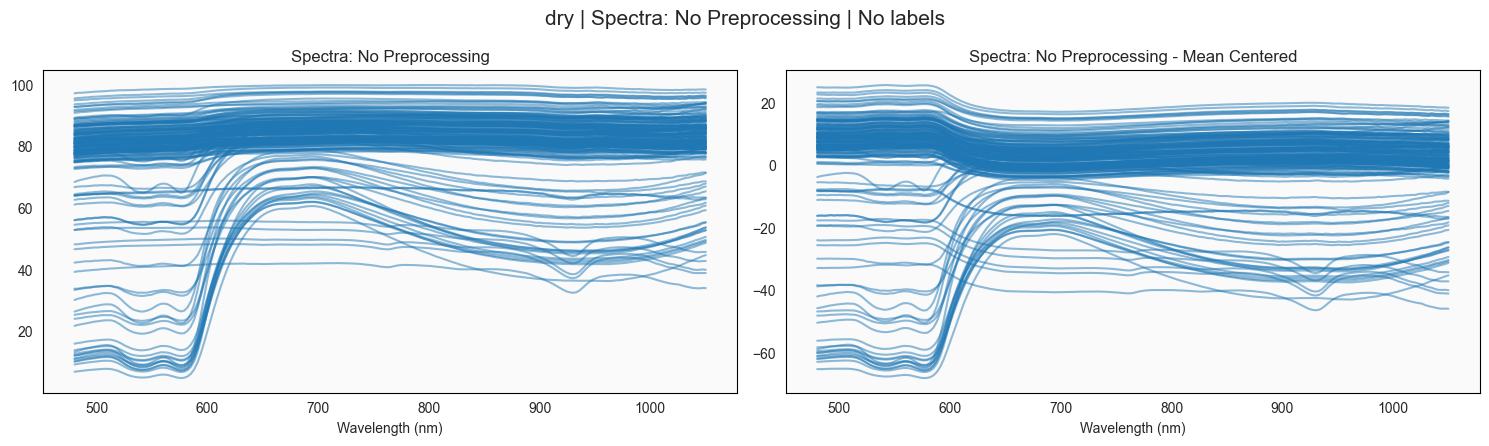

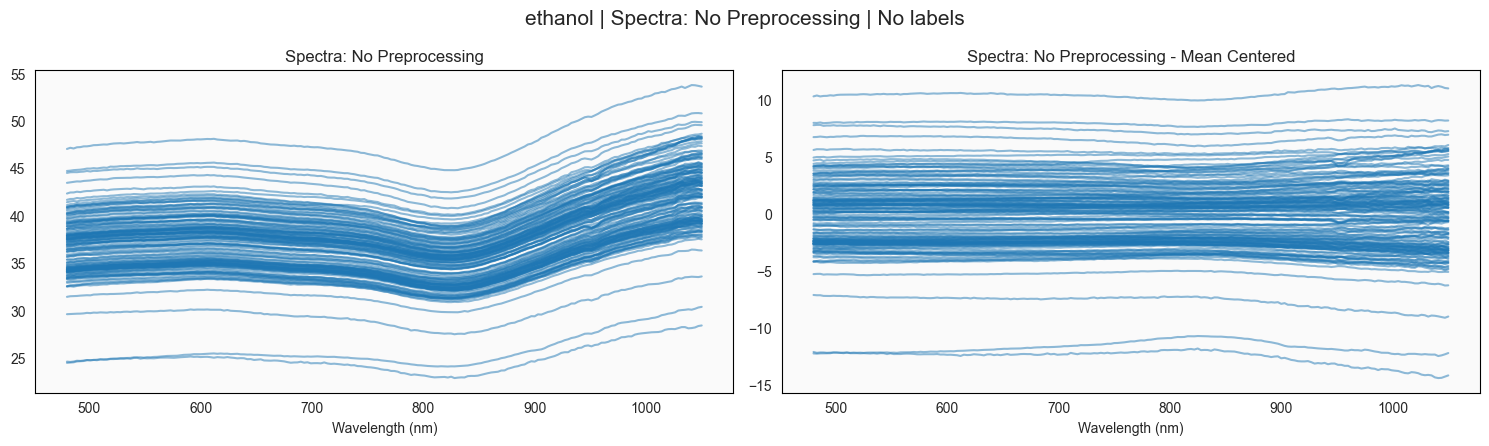

In [30]:
for selection in selections:
    print(f'Processing {selection} dataset')

    output_dir = Path(f"../data/visualisation/{selection}/")
    output_dir.mkdir(exist_ok=True, parents=True)

    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'

    plot_spectra(selected_df, labels=None,
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap);

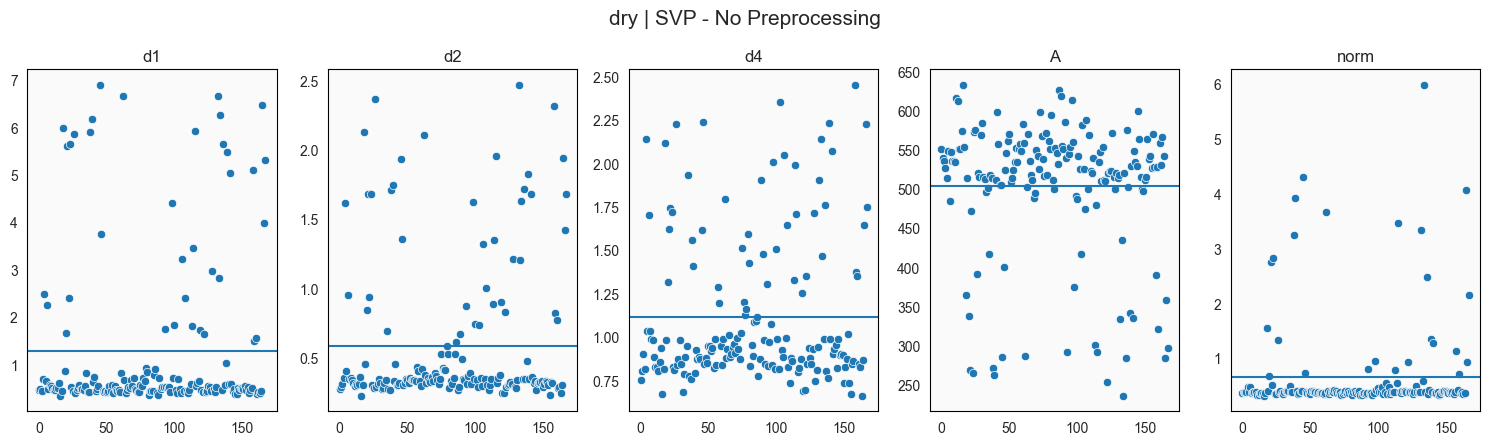

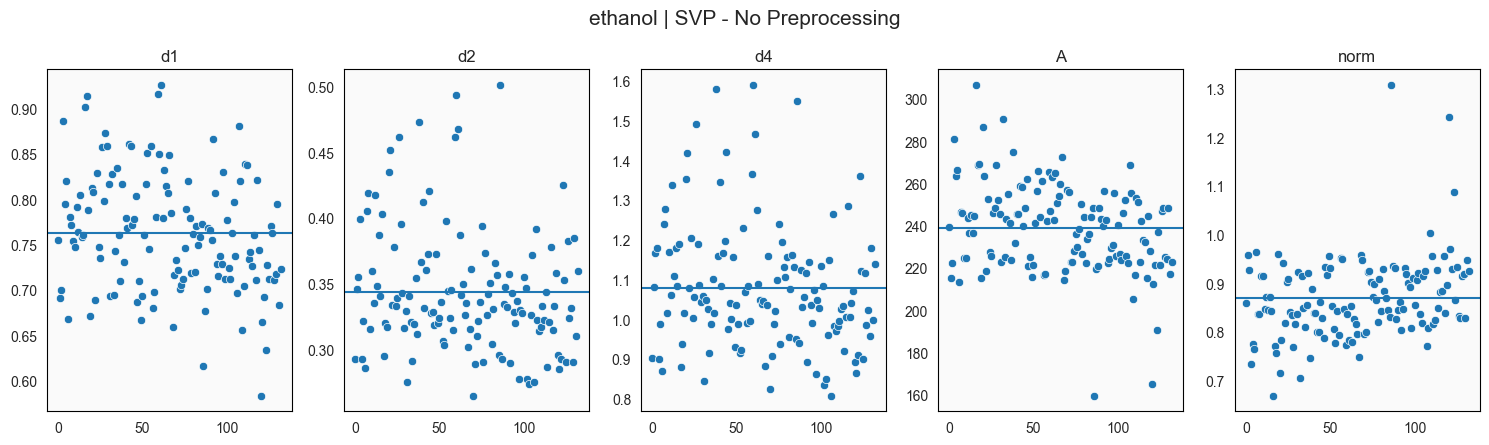

In [31]:
for selection in selections:
    
    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'
    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

## identify outlier samples

In [34]:
selections = datasets.copy()
#metrics cutoff
metrics = {
    0 : 'd1',
    1 : 'd2',
    2 : 'd4',
    3 : 'A',
    4 : 'norm'
}
choice = 4
maxval = 6
minval = 0

outliers = []

(168, 191) (168, 4)
False    168
Name: norm, dtype: int64
Number of samples outside the range: 0


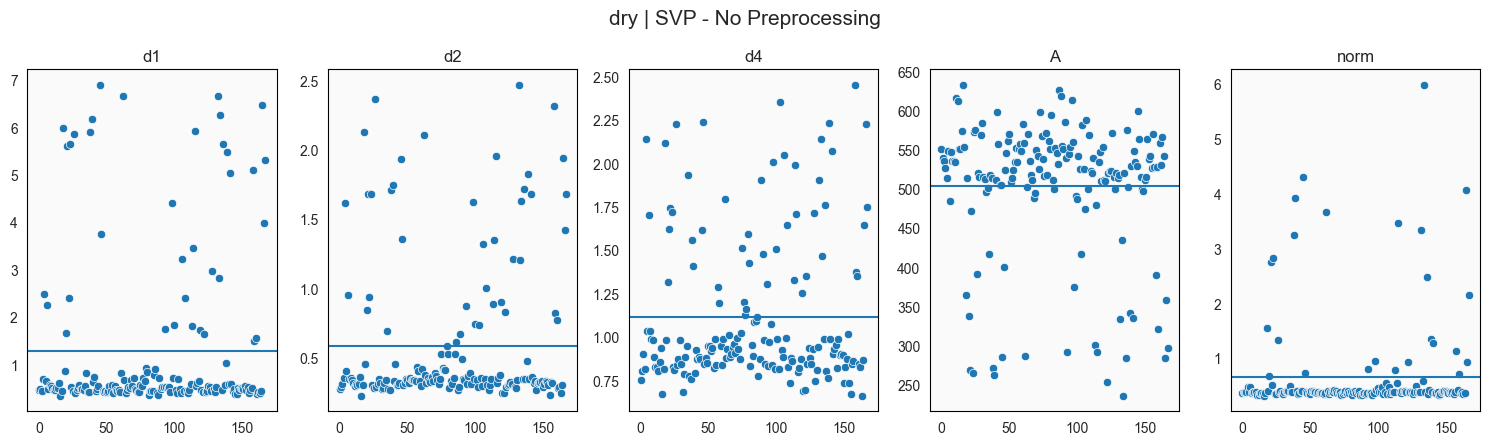

(133, 191) (133, 4)
False    133
Name: norm, dtype: int64
Number of samples outside the range: 0


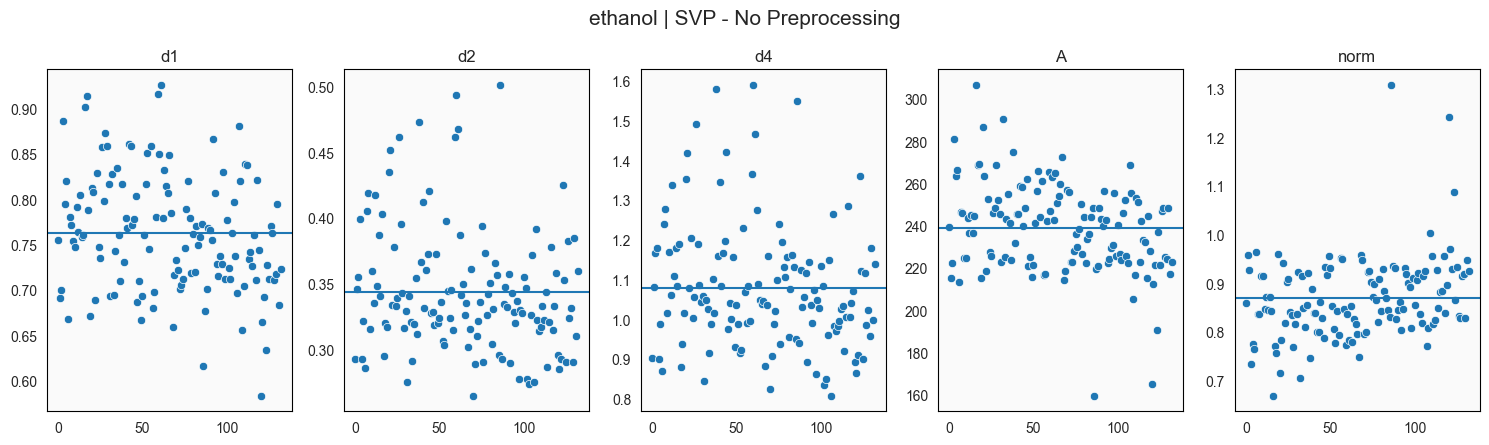

In [35]:
for selection in selections:

    # output_dir = Path(f"../data/visualisation/{selection}/")
    # output_dir.mkdir(exist_ok=True, parents=True)

    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']

    print(selected_df.shape, selected_labels.shape)

    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')

    svp_arr = spectral_vector_properties(selected_df, True)

    norm_data = svp_arr[metrics[choice]]

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    print(anomalous_mask.value_counts())

    norm_ax = plt.gcf().axes[choice]

    count = 0

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1
        elif norm_data.index[idx] in outliers:
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1

    print(f"Number of samples outside the range: {count}")
            
    plt.savefig(f"../data/visualisation/{selection}_svp.png")
    plt.show()
    plt.close()

Processing dry dataset
(168, 191) (168, 4)
False    168
Name: norm, dtype: int64


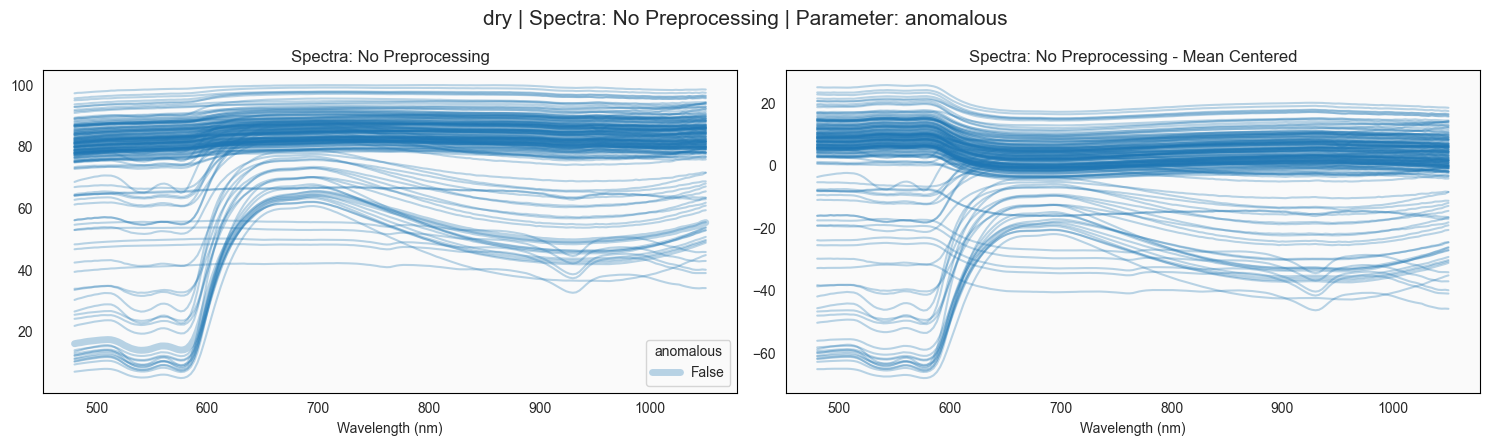

Processing ethanol dataset
(133, 191) (133, 4)
False    133
Name: norm, dtype: int64


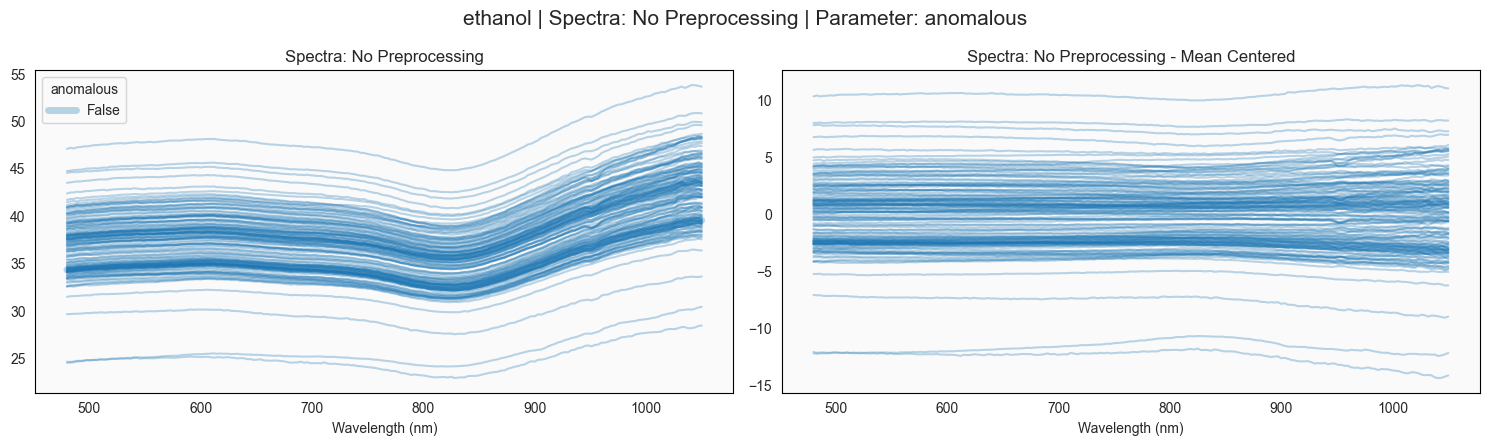

In [36]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'

    print(f'Processing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | svp_arr.index.isin(outliers)
    print(anomalous_mask.value_counts())

    # add a new column in check_df to label anomalous samples
    check_df = selected_df.copy(deep=True)
    check_df['anomalous'] = anomalous_mask
    # display(check_df[check_df['anomalous'] == True])

    plot_spectra(selected_df, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap)
    plt.savefig(f"../data/visualisation/{selection}_anomalous_spectra.png")
    plt.show()
    plt.close()

## filter outliers


Processing dry dataset
(168, 191) (168, 4)


,Condition,Patient,specimen_id,date_scanned
lot_id,,,,


Number of anomalous samples: 0


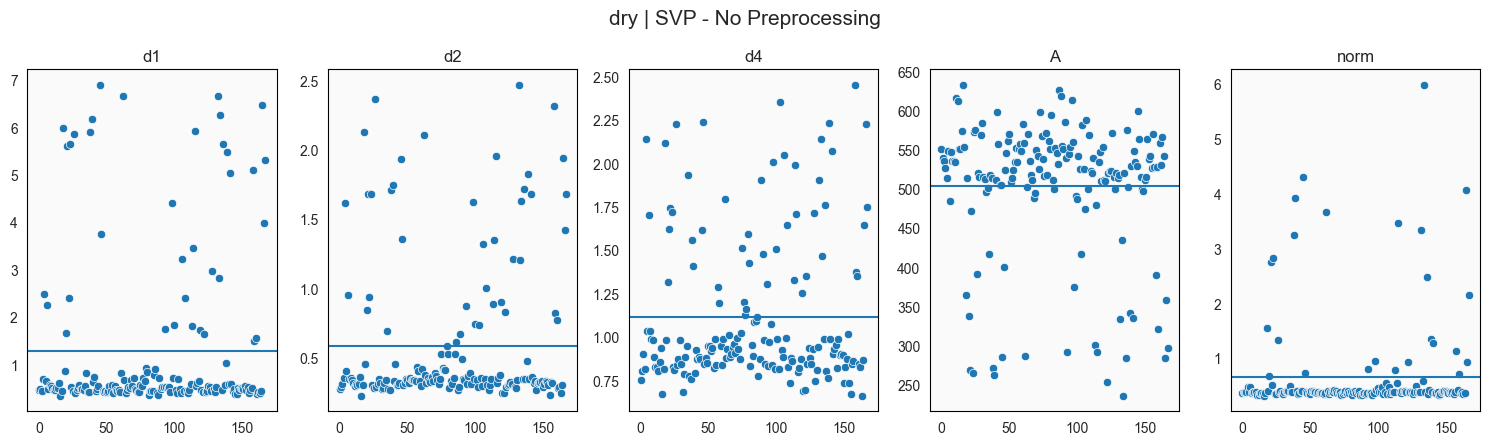

shapes after cleaning: (168, 191) (168, 4)

Processing ethanol dataset
(133, 191) (133, 4)


,Condition,Patient,specimen_id,date_scanned
lot_id,,,,


Number of anomalous samples: 0


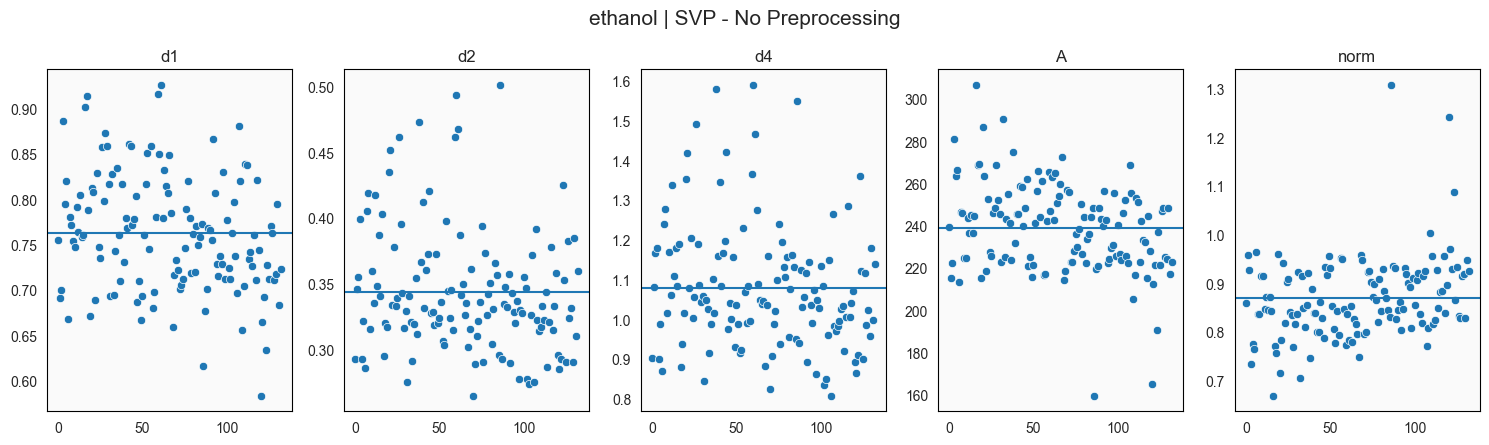

shapes after cleaning: (133, 191) (133, 4)


In [38]:
for selection in selections:

    output_dir = Path(f"../data/processed/")
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f'\nProcessing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | svp_arr.index.isin(outliers)
    
    cleaned_df = selected_df[~anomalous_mask]
    cleaned_labels = selected_labels[~anomalous_mask]

    display(selected_labels[anomalous_mask])

    count = 0

    print(f'Number of anomalous samples: {anomalous_mask.sum() + count}')
    
    SAMPLE_TYPE = f'{selection}'
    plot_svp(cleaned_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

    print(f'shapes after cleaning: {cleaned_df.shape} {cleaned_labels.shape}')

    cleaned_df.to_csv(output_dir/f"{selection}/cleaned_input.csv")
    cleaned_labels.to_csv(output_dir/f"{selection}/cleaned_label.csv")